In [2]:
from __future__ import division

import os

import csv
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import pandas as pd
import datetime
import pytz

import seaborn as sns
%matplotlib inline

from datetime import date, timedelta, datetime
from pytz import timezone
from dateutil.tz import tzutc, tzoffset
from dateutil import tz
from pandas import *

from scipy import stats

# Meters for each building in each catogory

Note: Original timestep is UTC, need to convert it to local time zone: UTC-05:00

In [3]:
# consider the holidays
holidays = pd.read_csv('holiday.csv', usecols=[0])
holidays['date'] = pd.to_datetime(pd.Series(holidays['date']), format='%m/%d/%y')
holidays['day'] = holidays.date.apply(lambda x: x.strftime('%Y-%m-%d'))

def MeterData_Format(data):
    data['date'] = data.index
#     data['power'] = data[[col for col in data.columns if "WA" in col]].sum(axis=1)
    data['day'] = map(lambda x: x.strftime('%Y/%m/%d'),data.index)
    data['time'] = map(lambda x: x.strftime('%H:%M'),data.index)
    data['month'] = map(lambda x: x.strftime('%m'),data.index)
    data['hour'] = map(lambda x: x.strftime('%H'),data.index)
    data['month'] = data.month.astype(int)
    data['hour'] = data.hour.astype(int)
    data['weekday'] = data.index.weekday
    data['holiday'] = map(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values,data.index)
    data['holiday'] = data.holiday.astype(int)
    
    return data

In [20]:
data = pd.read_csv('Office1.csv')
data.index = data['Date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y %H:%M'))
data.drop(data.columns[[0]],axis=1,inplace=True)
data.columns = ['power','oat']
data = MeterData_Format(data)

In [110]:
def CleanMeterData(BuildingID):
    data = pd.read_csv(BuildingID)
    data.index = data['Date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y %H:%M'))
    data.drop(data.columns[[0]],axis=1,inplace=True)
    data.columns = ['power','oat']
    df = MeterData_Format(data)
    
    df.fillna(method='pad')

    # calculate basepower on weekdays
    df.loc[:,'basepower'] = 0
    df.loc[:,'peakoat'] = 0

    # calculate the daily peak OAT
    PeakOAT = df.groupby(['day'])['oat'].max()

    for day in PeakOAT.index:
        df.loc[(df['day'] == day),'peakoat'] = PeakOAT[day]

    # subset the weekday and weekend power
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]

    # calculate the basepower on weekdays and weekend
    df_wd_base = df_wd.loc[(df_wd['peakoat'] < 60)]
    df_wd_basedaily = df_wd_base.pivot(index='time',columns='day',values='power')

    for tim in df_wd_basedaily.index:
        df.loc[(df['time'] == tim) & (df['weekday'] >= 0) & \
           (df['weekday'] <= 4) & (df['holiday'] == 0),'basepower'] = df_wd_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df.weekday.apply(lambda x: x in [5,6])),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df['holiday'] == 1),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]

    df.loc[:,'hvac'] = df.power - df.basepower
    
    return data, df

In [111]:
data, df = CleanMeterData('Office1.csv')

In [128]:
customers = pd.read_csv('../D1977_OFFICE_LBNL.csv')
usrInput = customers[customers['addr_line1_txt'].str.contains('345 CALIFORNIA')]
usrInput.index = usrInput.sa_id


## 1. Generate all the basic metric from meter data and weather data

In [145]:
usrOutput = {'sa_id': usrInput.sa_id, 'addr': usrInput.addr_line1_txt, 'cty': usrInput.cty_nm, 
             'zip': usrInput.zip_5_dgt, 'PGE_CZ': 5, 'CEC_CZ':3
            }

In [150]:
usrOutput['Peak_kW'] = df.power.max()
usrOutput['Peak_kW_timestamp'] = df.power.idxmax()
usrOutput['SLAP'] = 'SLAP_PGSF-APND'
usrOutput['PDP_TOU'] = 1.0

In [209]:
df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
df_cssb = df_wd.loc[(df_wd['month'] >= 5) & (df_wd['month'] <= 10),['power','hour','time','oat']]
CSSB = df_cssb.groupby(['time'])['power'].mean()

In [186]:
hotDays = df_wd.groupby(['day'])['oat'].max().sort_values(ascending=False)[0:10]
hotDaysPower = df.loc[df['day'].isin(hotDays.index),['power', 'oat','time','day']]

In [223]:
custMetrics = hotDaysPower.pivot(index='time',columns='day',values='power')
custMetrics.columns = ['hotDay0','hotDay1','hotDay2','hotDay3','hotDay4','hotDay5','hotDay6','hotDay7','hotDay8','hotDay9']
custMetrics['cssb'] = df_cssb.groupby(['time'])['power'].mean()
custMetrics['hotDay'] = hotDaysPower.groupby(['time'])['power'].mean()
custMetrics['peakDay'] = df.loc[df['day'] == df.power.idxmax().strftime('%Y/%m/%d'),'power'].values
# custMetrics['hour'] = df.loc[df['day'] == df.power.idxmax().strftime('%Y/%m/%d'),'hour'].values

In [232]:
DR_Equations = pd.read_csv('../results/TechOffice/DREquations.csv')
DR_Equations.index = DR_Equations.DR_Controls

In [262]:
custOAT = hotDaysPower.pivot(index='time',columns='day',values='oat')
custOAT.columns = ['hotDayOAT0','hotDayOAT1','hotDayOAT2','hotDayOAT3','hotDayOAT4','hotDayOAT5','hotDayOAT6',
                   'hotDayOAT7','hotDayOAT8','hotDayOAT9']
custOAT['cssb_oat'] = df_cssb.groupby(['time'])['oat'].mean()
custOAT['hotDay_oat'] = hotDaysPower.groupby(['time'])['oat'].mean()
custOAT['peakDay_oat'] = df.loc[df['day'] == df.power.idxmax().strftime('%Y/%m/%d'),'oat'].values
custOAT['hour'] = df.loc[df['day'] == df.power.idxmax().strftime('%Y/%m/%d'),'hour'].values
custOAT['NoPrecool_Reset2F_alpha'] = np.nan
custOAT['NoPrecool_Reset2F_beta'] = np.nan
custOAT['NoPrecool_Reset4F_alpha'] = np.nan
custOAT['NoPrecool_Reset4F_beta'] = np.nan
custOAT['NoPrecool_Reset6F_alpha'] = np.nan
custOAT['NoPrecool_Reset6F_beta'] = np.nan
custOAT['Precool2F_Reset2F_alpha'] = np.nan
custOAT['Precool2F_Reset2F_beta'] = np.nan
custOAT['Precool2F_Reset4F_alpha'] = np.nan
custOAT['Precool2F_Reset4F_beta'] = np.nan
custOAT['Precool2F_Reset6F_alpha'] = np.nan
custOAT['Precool2F_Reset6F_beta'] = np.nan


In [263]:
for hour in range(14,18):
    custOAT.loc[custOAT['hour'] == hour, ['NoPrecool_Reset2F_alpha','NoPrecool_Reset2F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 0) & (DR_Equations['reset'] == 2), ['alpha_2','beta_2']].values
    custOAT.loc[custOAT['hour'] == hour, ['NoPrecool_Reset4F_alpha','NoPrecool_Reset4F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 0) & (DR_Equations['reset'] == 4), ['alpha_2','beta_2']].values
    custOAT.loc[custOAT['hour'] == hour, ['NoPrecool_Reset6F_alpha','NoPrecool_Reset6F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 0) & (DR_Equations['reset'] == 6), ['alpha_2','beta_2']].values

    custOAT.loc[custOAT['hour'] == hour, ['Precool2F_Reset2F_alpha','Precool2F_Reset2F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 2) & (DR_Equations['reset'] == 2), ['alpha_2','beta_2']].values
    custOAT.loc[custOAT['hour'] == hour, ['Precool2F_Reset4F_alpha','Precool2F_Reset4F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 2) & (DR_Equations['reset'] == 4), ['alpha_2','beta_2']].values
    custOAT.loc[custOAT['hour'] == hour, ['Precool2F_Reset6F_alpha','Precool2F_Reset6F_beta']] = \
        DR_Equations.loc[(DR_Equations['hour'] == hour) & (DR_Equations['precool'] == 2) & (DR_Equations['reset'] == 6), ['alpha_2','beta_2']].values


In [264]:
result = pd.concat([custMetrics, custOAT], axis=1)
result.to_csv('../results/TechOffice/custMetrics.csv')

In [274]:
usrOutput['DR_Capacity'] = np.mean(result.peakDay * (result.Precool2F_Reset6F_beta + result.peakDay_oat * result.Precool2F_Reset6F_alpha)/100)

In [275]:
pd.DataFrame(usrOutput).to_csv('../results/TechOffice/CustSummary.csv')

## Create the entire dataset from meter data and weather data

In [87]:
# Resample data into hourly demand
def Load_Duration(data, BuildingID):
    HourlyLoad = data['2015'].resample('H').mean()
    HourlyLoad_order = HourlyLoad.sort_values(by=['power'],ascending=False)['power']

    sns.set_context('poster')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6), facecolor='w', edgecolor='k', sharex=False)

    ax1.plot(range(len(HourlyLoad)),HourlyLoad_order,label='Hourly Demand')
    ax1.set_xlabel('Hour of Year 2015')
    ax1.set_ylabel('Power, kW')
    ax1.set_title(BuildingID + ':Building Load Duration Curve in 2015')
    ax1.legend()
    
    df_wd = data.loc[(data['weekday'] >= 0) & (data['weekday'] <= 4)]
    df_wd_daily = df_wd.pivot(index='time',columns='day',values='power')
    
    df_wd_daily.plot(ax=ax2,c='gray',alpha=0.8)
    ax2.plot(df_wd_daily.mean(axis=1),c='b',label='Average Power')
    ax2.set_ylabel('Power, [kW]')
    ax2.set_xlabel('Hour of Day')
    ax2.set_title(BuildingID + ':Daily Power on Weekdays in 2015')
    ax2.legend().set_visible(False)
    
    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_LoadCurve.png',dpi=300, format='png',bbox_inches='tight')

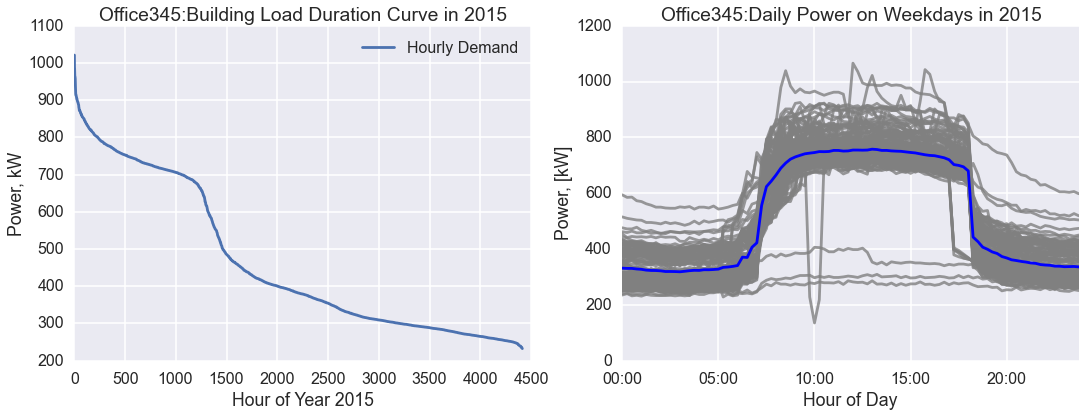

In [88]:
Load_Duration(data,'Office345')

In [89]:
# Resample data into hourly demand
def hourly_boxplot(data, BuildingID):
    
    df = data['2015']
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4)]
    df_wk = df.loc[df.weekday.apply(lambda x: x in [5,6])]
    df_wd_hourly = df_wd.pivot(index='date',columns='hour',values='power')
    df_wk_hourly = df_wk.pivot(index='date',columns='hour',values='power')
    
    sns.set_context('poster')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6), facecolor='w', edgecolor='k', sharey=True)
    fig.subplots_adjust(hspace = .1, wspace = .1)

    df_wd_hourly.boxplot(ax=ax1)
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Power, kW')
    ax1.set_title(BuildingID + ':Hourly Distribution on Weekdays in 2015')
    
    df_wk_hourly.boxplot(ax=ax2)
    ax2.set_ylabel('Power, [kW]')
    ax2.set_xlabel('Hour of Day')
    ax2.set_title(BuildingID + ':Hourly Distribution on Weekends in 2015')
    
    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_BoxPlot.png',dpi=300, format='png',bbox_inches='tight')
    
    return fig

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


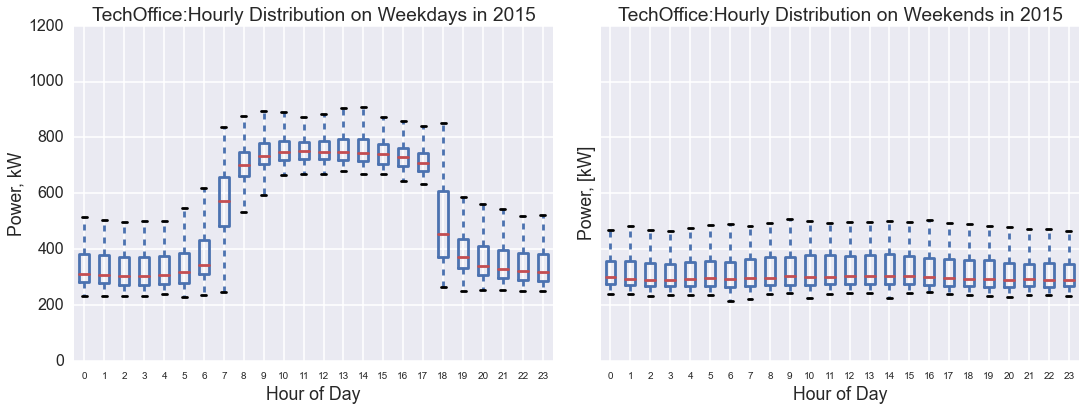

In [90]:
fig = hourly_boxplot(data,'TechOffice')

In [104]:
def hourly_scatter(data, BuildingID):
    data2 = data.copy()

    # calculate weather sensitivity
    df2 = data2['2015'].resample('H').mean()
    df_wd = df2.loc[(df2['weekday'] >= 0) & (df2['weekday'] <= 4) & (df2['holiday'] == 0)]
    df_wk = df2.loc[(df2.weekday.apply(lambda x: x in [5,6])) & (df2['holiday'] == 1)]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6), facecolor='w', edgecolor='k', sharey=True)
    fig.subplots_adjust(hspace = .1, wspace = .1)

    ax1.plot(df_wd['oat'],df_wd['power'],'o',ms=4)
    ax1.set_xlabel('Outside Air Temperature, [$^\circ$F]')
    ax1.set_ylabel('Power, [kW]')
    ax1.set_title(BuildingID + ':Power & OAT on Weekdays in 2015')

    df2 = data2['2015'].resample('H').mean()
    df_wd = df2.loc[(df2['weekday'] >= 0) & (df2['weekday'] <= 4) & (df2['holiday'] == 0) & (df2['oat'] >= 68)]
    df_wk = df2.loc[(df2.weekday.apply(lambda x: x in [5,6])) & (df2['holiday'] == 1)]

    ax2.plot(df_wd['oat'],df_wd['power'],'o',ms=4)
    ax2.set_xlabel('Outside Air Temperature, [$^\circ$F]')
    ax2.set_ylabel('Power, [kW]')
    ax2.set_title(BuildingID + ':Power & OAT>=68$^\circ$F on Weekdays in 2015')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_PowerOAT.png',dpi=300, format='png',bbox_inches='tight')
    

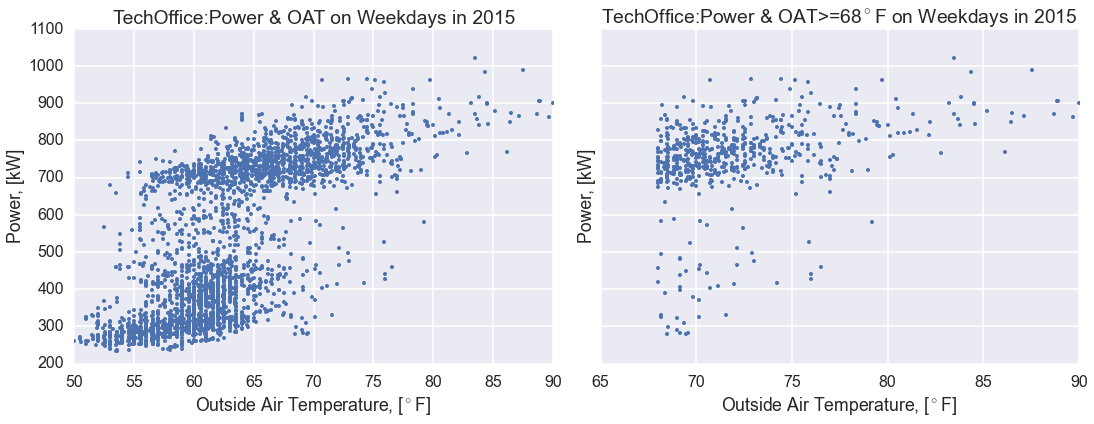

In [105]:
hourly_scatter(data,'TechOffice')

In [106]:
def hourly_BaseHVAC(df, BuildingID):
    # calculate basepower on weekdays
    df = df['2015']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]

    df_wd_base = df_wd.loc[(df_wd['peakoat'] < 68)]
    df_wd_basedaily = df_wd_base.pivot(index='time',columns='day',values='power')

    fig, axes = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k', sharey=False)
    fig.subplots_adjust(hspace = .3, wspace = .2)

    df_wd_basedaily.plot(ax=axes[0,0],c='gray',alpha=0.8)
    axes[0,0].plot(df_wd_basedaily.mean(axis=1),c='b',label='Average Power')
    axes[0,0].set_ylabel('Power, [kW]')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_title(BuildingID + ':Power & OAT<=68$^\circ$F on Weekdays in 2015')
    axes[0,0].legend().set_visible(False)
    
    # calculate basepower on weekends and holidays

    df_wk_basedaily.plot(ax=axes[0,1],c='gray',alpha=0.8)
    axes[0,1].plot(df_wk_basedaily.mean(axis=1),c='r',label='Average Power')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Power, [kW]')
    axes[0,1].set_title(BuildingID + ':Power & OAT<=68$^\circ$F on Weekends in 2015')
    axes[0,1].legend().set_visible(False)
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]
    df_wd_hvachourly = df_wd_hvac.pivot(index='date',columns='hour',values='hvac')
    
    df_wd_hvachourly.boxplot(ax=axes[1,0])
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('HVAC Power, kW')
    axes[1,0].set_title(BuildingID + ':HVAC Power Distribution on Weekdays in 2015')
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 80)]
    df_wd_hvachourly = df_wd_hvac.pivot(index='date',columns='hour',values='hvac')
    
    df_wd_hvachourly.boxplot(ax=axes[1,1])
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('HVAC Power, kW')
    axes[1,1].set_title(BuildingID + ':HVAC Power Distribution on Weekdays in 2015')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_BaseHVAC.png',dpi=300, format='png',bbox_inches='tight')
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


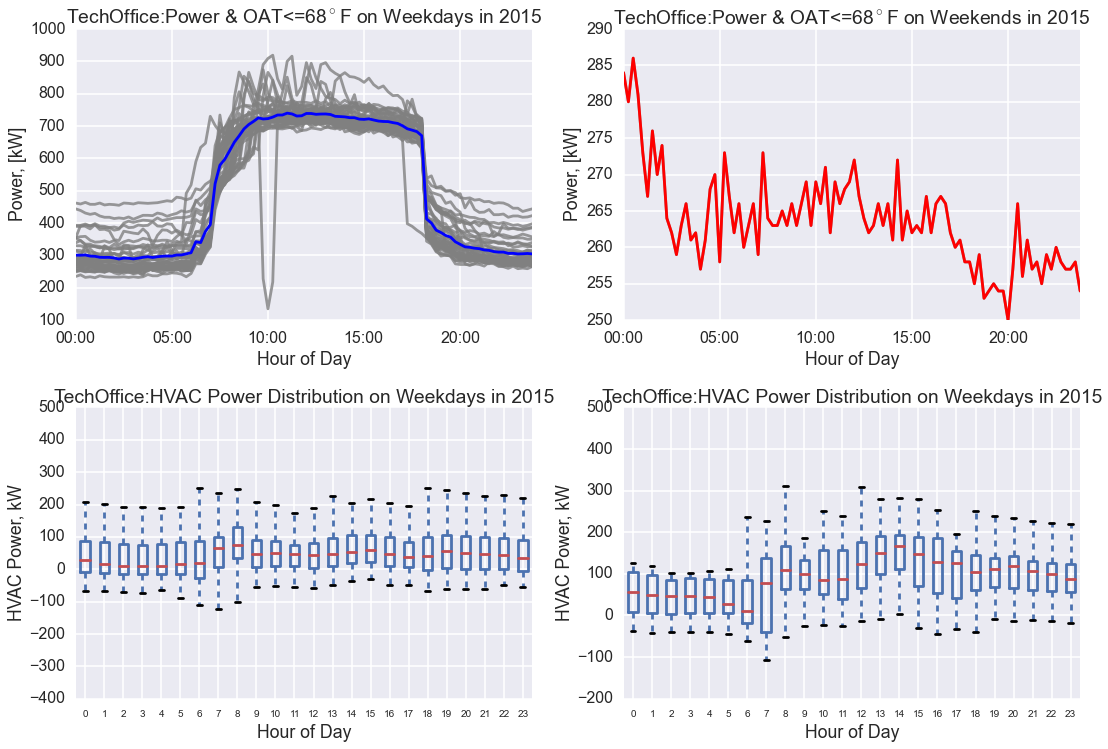

In [107]:
hourly_BaseHVAC(df,'TechOffice')

In [97]:
def hvac_scatter_1(df, BuildingID):
    df = df['2015']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]

    fig, axes = plt.subplots(2,3, figsize=(18, 9), facecolor='w', edgecolor='k', sharey=True, sharex=True)
    fig.subplots_adjust(hspace = .2, wspace = .1)
    
    for i in range(6,12,1):
        x1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].oat
        y1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].hvac
        x2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].oat
        y2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].hvac
        
        TempBreaks = [68,95]
        try:
            z1 = np.polyfit(x1,y1,1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1),TempBreaks[0],100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(TempBreaks[0], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)

            axes.ravel()[i-6].plot(x1,y1,'o',label='OAT <= 68F',ms=4)
            axes.ravel()[i-6].plot(x2, y2, 'o', label = 'OAT > 68F',ms=4)
            axes.ravel()[i-6].plot(xp1,p1(xp1),'-')
            axes.ravel()[i-6].plot(xp2, p2(xp2), '-')
            axes.ravel()[i-6].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        except TypeError:
            print "Empty OAT >= 68F"
        
        if i >= 9:
            axes.ravel()[i-6].set_xlabel('Outside Air Temperature, [$^\circ$F]')
        axes.ravel()[i-6].set_ylabel('HVAC Power, [kW]')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_Linear_1.png',dpi=300, format='png',bbox_inches='tight')
    

In [98]:
def hvac_scatter_2(df, BuildingID):
    df = df['2015']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]

    fig, axes = plt.subplots(2,3, figsize=(18, 9), facecolor='w', edgecolor='k', sharey=True, sharex=True)
    fig.subplots_adjust(hspace = .2, wspace = .1)
    
    for i in range(12,18,1):
        x1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].oat
        y1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].hvac
        x2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].oat
        y2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].hvac
        
        TempBreaks = [68,95]
        try:
            z1 = np.polyfit(x1,y1,1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1),TempBreaks[0],100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(TempBreaks[0], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)

            axes.ravel()[i-12].plot(x1,y1,'o',label='OAT <= 68F',ms=4)
            axes.ravel()[i-12].plot(x2, y2, 'o', label = 'OAT > 68F',ms=4)
            axes.ravel()[i-12].plot(xp1,p1(xp1),'-')
            axes.ravel()[i-12].plot(xp2, p2(xp2), '-')
            axes.ravel()[i-12].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        except TypeError:
            print "Empty OAT >= 68F"
        
        if i >= 15:
            axes.ravel()[i-12].set_xlabel('Outside Air Temperature, [$^\circ$F]')
        axes.ravel()[i-12].set_ylabel('HVAC Power, [kW]')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_Linear_2.png',dpi=300, format='png',bbox_inches='tight')
    

In [108]:
def building_scatter_2(df, BuildingID):
    df = df['2015']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]

    fig, axes = plt.subplots(2,3, figsize=(18, 9), facecolor='w', edgecolor='k', sharey=True, sharex=True)
    fig.subplots_adjust(hspace = .2, wspace = .1)
    
    for i in range(12,18,1):
        x1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','power']].oat
        y1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','power']].power
        x2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','power']].oat
        y2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','power']].power
        
        TempBreaks = [68,95]
        try:
            z1 = np.polyfit(x1,y1,1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1),TempBreaks[0],100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(TempBreaks[0], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)

            axes.ravel()[i-12].plot(x1,y1,'o',label='OAT <= 68F',ms=4)
            axes.ravel()[i-12].plot(x2, y2, 'o', label = 'OAT > 68F',ms=4)
            axes.ravel()[i-12].plot(xp1,p1(xp1),'-')
            axes.ravel()[i-12].plot(xp2, p2(xp2), '-')
            axes.ravel()[i-12].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        except TypeError:
            print "Empty OAT >= 68F"
        
        if i >= 15:
            axes.ravel()[i-12].set_xlabel('Outside Air Temperature, [$^\circ$F]')
        axes.ravel()[i-12].set_ylabel('Whole Building Power, [kW]')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_BldgLinear_2.png',dpi=300, format='png',bbox_inches='tight')
    

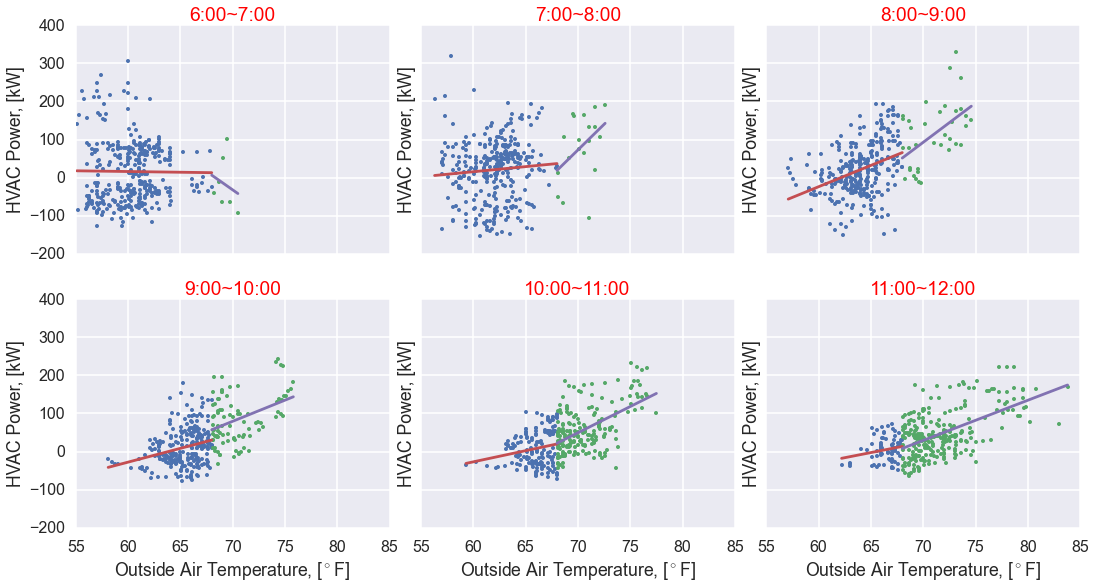

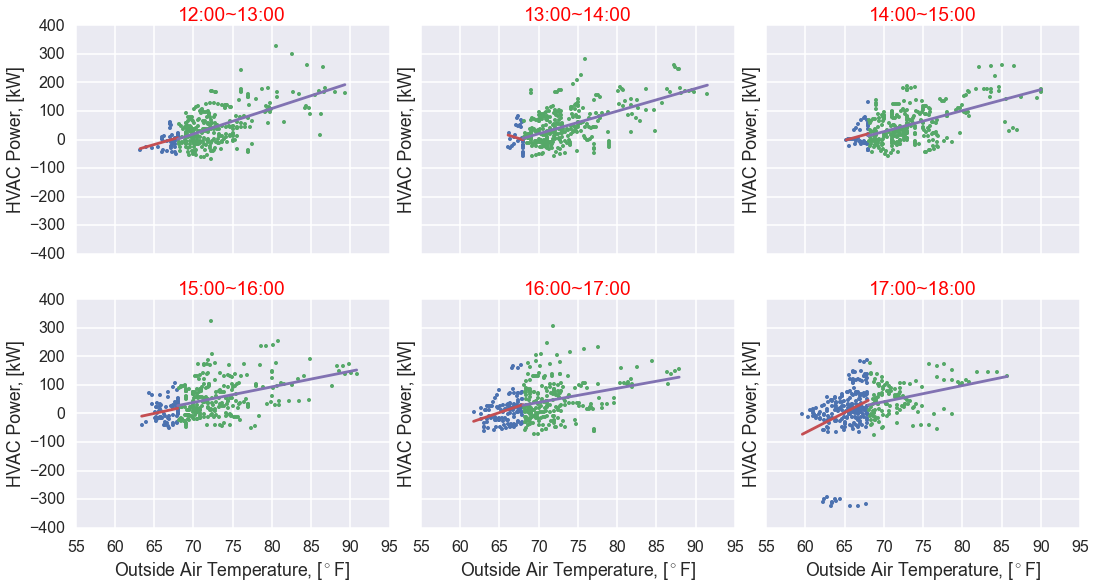

In [99]:
hvac_scatter_1(df,'TechOffice')
hvac_scatter_2(df,'TechOffice')

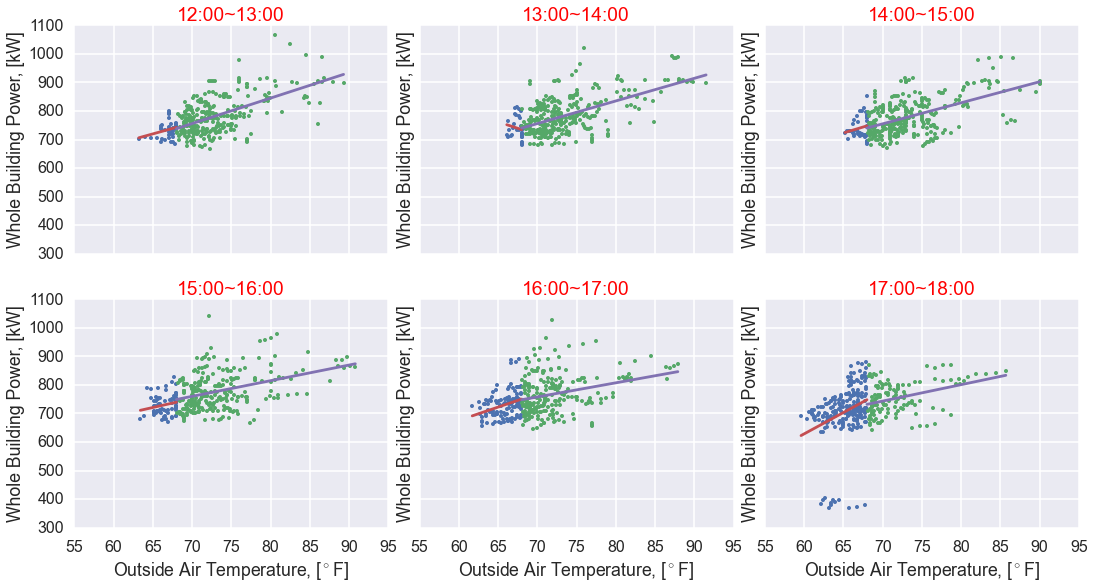

In [109]:
building_scatter_2(df,'TechOffice')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning

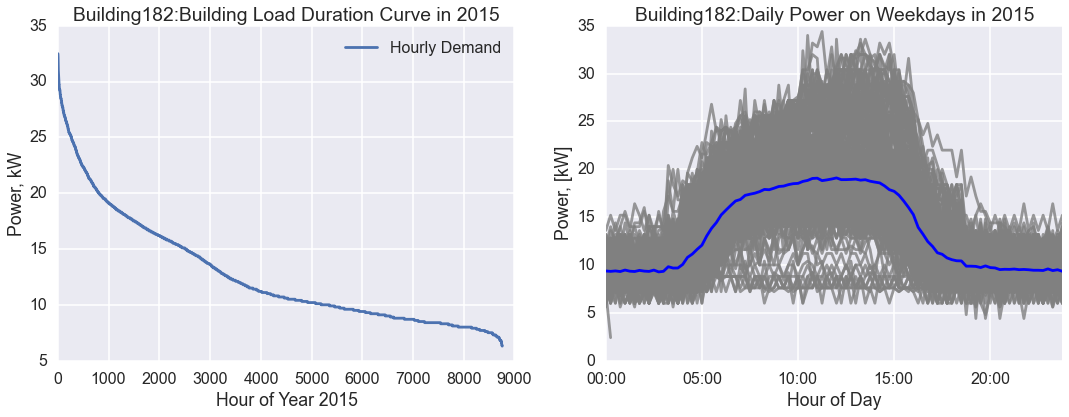

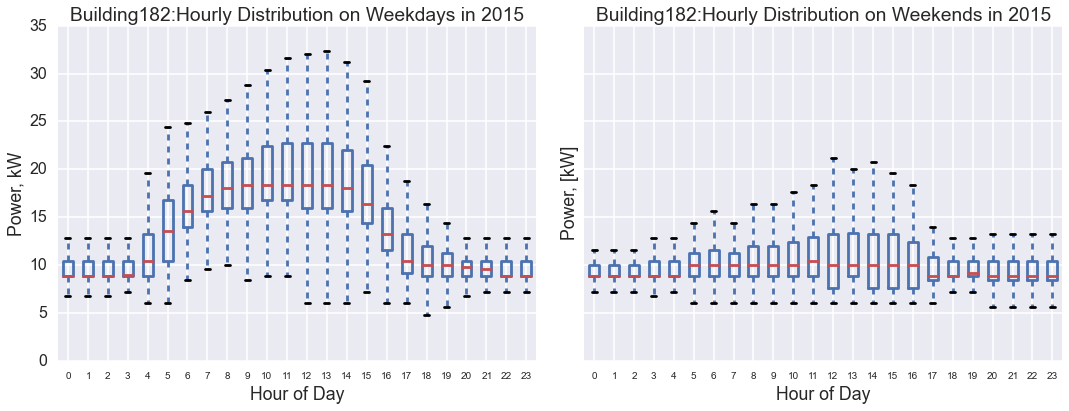

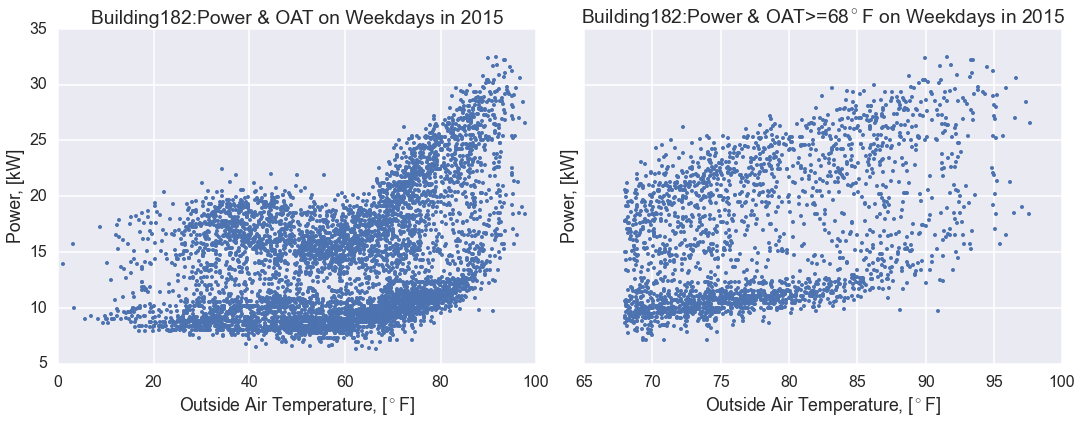

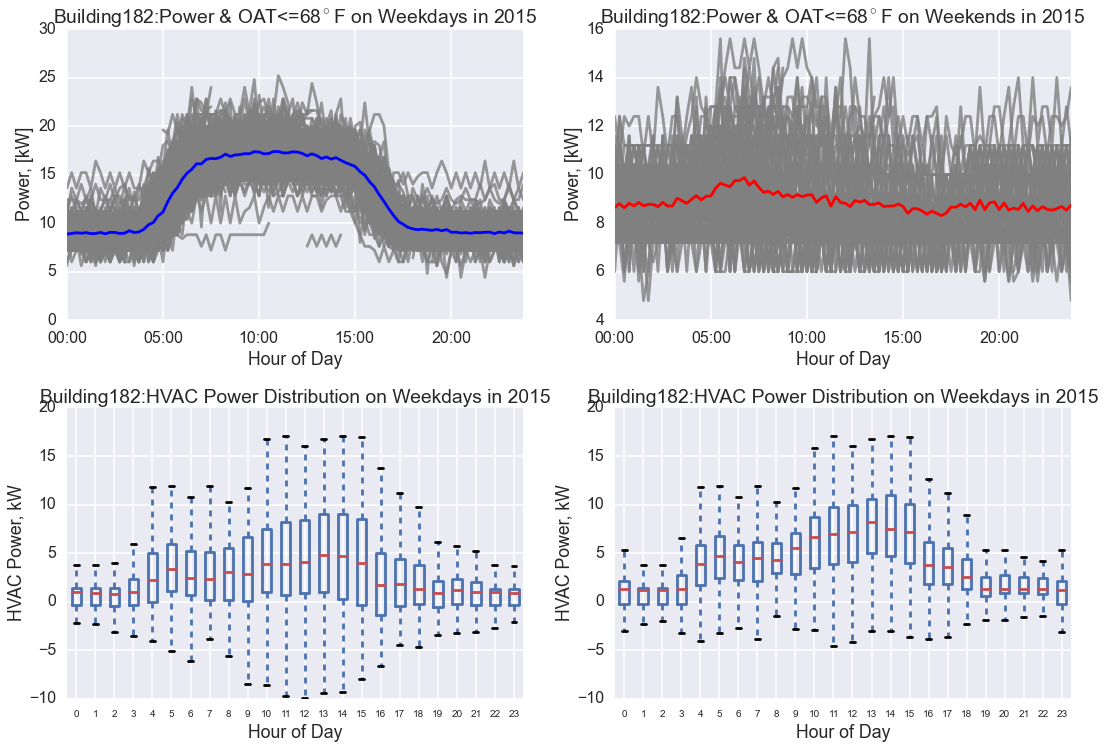

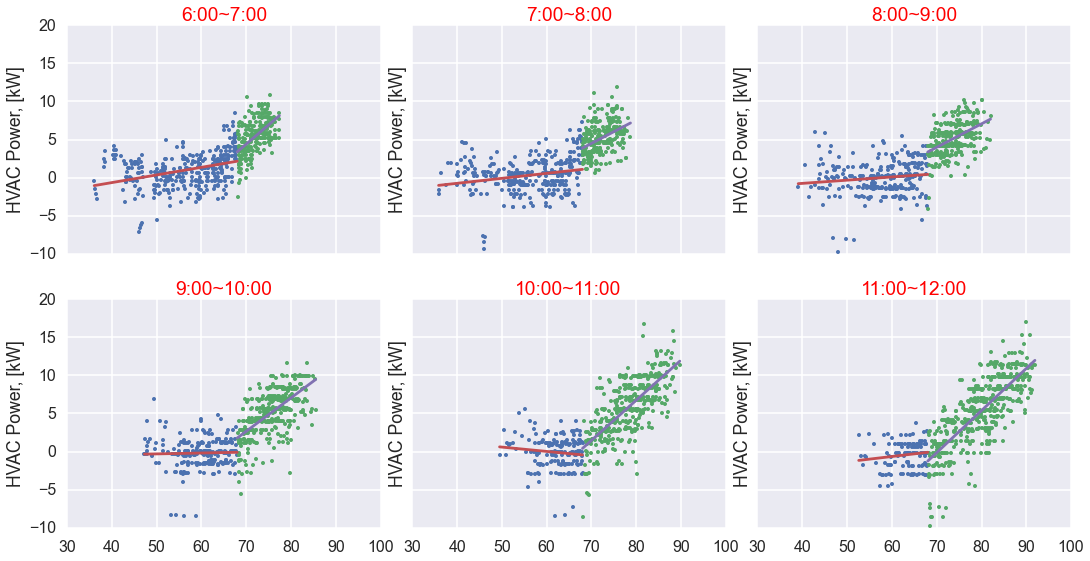

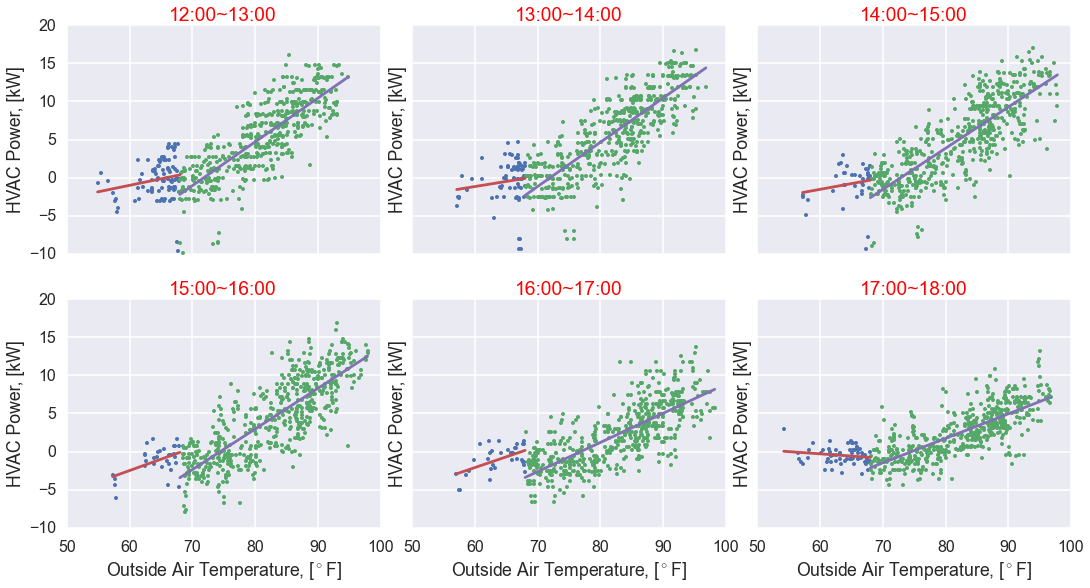

In [333]:
Load_Duration(data,'Building182')
hourly_boxplot(data,'Building182')
hourly_scatter(data,weather,'Building182')
hourly_BaseHVAC(df,'Building182')
hvac_scatter_1(df,'Building182')
hvac_scatter_2(df,'Building182')